In [13]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

# Data importation
df = pd.read_csv('cyber_bully_cleaned.csv')
df = df.dropna()

df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

c:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/3
Batch 1/980
Batch 2/980
Batch 3/980
Batch 4/980
Batch 5/980
Batch 6/980
Batch 7/980
Batch 8/980
Batch 9/980
Batch 10/980
Batch 11/980
Batch 12/980
Batch 13/980
Batch 14/980
Batch 15/980
Batch 16/980
Batch 17/980
Batch 18/980
Batch 19/980
Batch 20/980
Batch 21/980
Batch 22/980
Batch 23/980
Batch 24/980
Batch 25/980
Batch 26/980
Batch 27/980
Batch 28/980
Batch 29/980
Batch 30/980
Batch 31/980
Batch 32/980
Batch 33/980
Batch 34/980
Batch 35/980
Batch 36/980
Batch 37/980
Batch 38/980
Batch 39/980
Batch 40/980
Batch 41/980
Batch 42/980
Batch 43/980
Batch 44/980
Batch 45/980
Batch 46/980
Batch 47/980
Batch 48/980
Batch 49/980
Batch 50/980
Batch 51/980
Batch 52/980
Batch 53/980
Batch 54/980
Batch 55/980
Batch 56/980
Batch 57/980
Batch 58/980
Batch 59/980
Batch 60/980
Batch 61/980
Batch 62/980
Batch 63/980
Batch 64/980
Batch 65/980
Batch 66/980
Batch 67/980
Batch 68/980
Batch 69/980
Batch 70/980
Batch 71/980
Batch 72/980
Batch 73/980
Batch 74/980
Batch 75/980
Batch 76/980
Batch 77/98

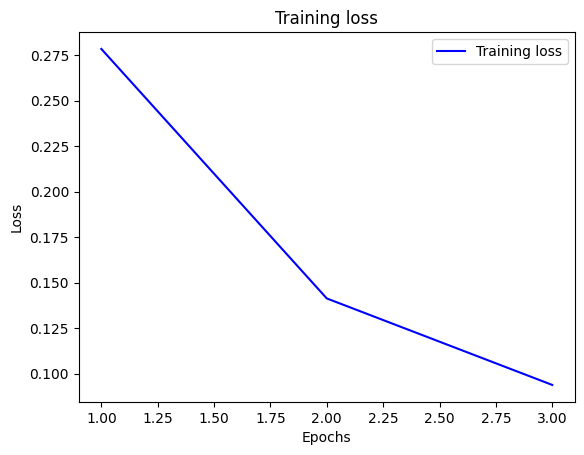

In [ ]:
# BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased', return_dict=False).to(device)
x = df['tweet_text']
y = df['cyberbullying_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

encoded_train = tokenizer.batch_encode_plus(
    x_train.to_list(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    return_tensors='pt',
    truncation=True
)

encoded_test = tokenizer.batch_encode_plus(
    x_test.to_list(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    return_tensors='pt',
    truncation=True
)

train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], torch.tensor(y_train.to_list()))
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)


test_dataset = TensorDataset(encoded_test['input_ids'], encoded_test['attention_mask'], torch.tensor(y_test.to_list()))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(pooled_output)
        return self.fc(output)
    
def model_train(train_dataloader, epoch_num, learning_rate):
    model = BERT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epoch_num
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    total_loss = []
    total_accuracy = []
    for epoch in range(epoch_num):
        model.train()
        running_loss = 0
        print(f'Epoch {epoch+1}/{epoch_num}')
        for id, batch in enumerate(train_dataloader):
            print(f'Batch {id+1}/{len(train_dataloader)}')
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f'Epoch {epoch+1}/{epoch_num} Loss: {running_loss/len(train_dataloader)}')
        accuracy, y_pred = model_test(model, test_dataloader, epoch_num)
        total_loss.append(running_loss/len(train_dataloader))
        total_accuracy.append(accuracy)
    return total_loss, total_accuracy, epoch_num, learning_rate, y_pred
        
            
def model_test(model, test_dataloader, epoch_num):
    model.eval()
    y_pred = []
    with torch.no_grad():
        correct = 0
        total = 0
        for id, batch in enumerate(test_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            output = model(input_ids, attention_mask)
            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f'Accuracy: {accuracy}')
    return accuracy, y_pred

        
total_loss, total_accuracy, num_epochs, learning_rate, y_pred = model_train(train_dataloader, 3, 2e-5)



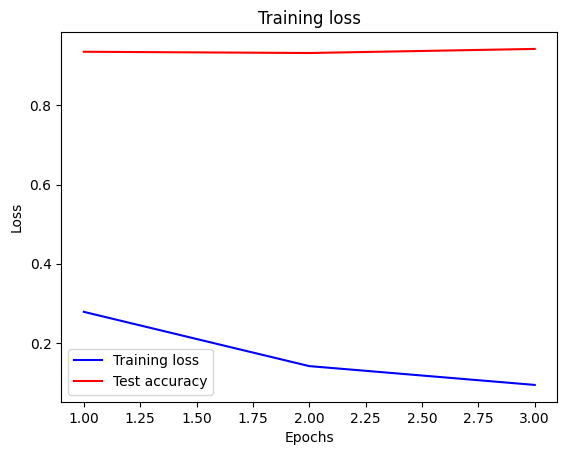

In [ ]:
types_of_bullying = ["religion","age","ethnicity","gender","not bullying"]
print('Classification Report for BERT :\n', classification_report(y_test, y_pred, target_names=types_of_bullying))
epochs = range(1, num_epochs+1)

plt.figure
plt.plot(epochs, total_loss, 'b', label='Training loss')
plt.plot(epochs, total_accuracy, 'r', label='Test accuracy')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()